# S2 - Spatial transferbility

Transfer the trained model to predict data from Weser Ems in 2013, 2014, 2015, 2016, 2018

### 1.0 Loading libraries and setting path

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
import skopt

from tensorflow.keras.models import load_model
import joblib

2023-06-22 22:18:02.672408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 22:18:03.675668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-06-22 22:18:03.675794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/

In [3]:
os.chdir('/home/pc4dl/SYM2')

In [4]:
print("Tensorflow Version: ", tf. __version__) 
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.11.0
Tensorflow Probability Version:  0.18.0


### 2.0 Define functions for reading, prepare and visualising data

In [5]:
def preapre_df(df):
    """
    This function read the dataframe and filter out the unwanted years and generate seperate
    dataframes for a) only with SR bands, b) only with VIs, and c) both with SR bands & VIs.
    """
    year_list = [*range(2010, 2019, 1)]
    df_years = df[df['year'].isin(year_list)]
    df_dropna = df_years.dropna()
    
    df_sr = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 
                               17, 18, 19, 20, 21, 22, 
                               27, 28, 29, 30, 31, 32, 
                               37, 38, 39, 40, 41, 42]]
    
    df_vi = df_dropna.iloc[:, [0, 47, 5,  
                               13, 14, 15, 16, 
                               23, 24, 25, 26, 
                               33, 34, 35, 36, 
                               43, 44, 45, 46]]
    df_sr_vi = df_dropna.iloc[:, [0, 47, 5,  
                               7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
                               27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 
                               37, 38, 39, 40, 41, 42, 43, 44, 45, 46]]
    
    return df_sr, df_vi, df_sr_vi

def s2_df(df):
    
    df2 = df.copy()
    
    non_test_years = [2010, 2011, 2012]
    
    df_y = df2[~df2['year'].isin(non_test_years)]
    
    return df_y


def norm(df):
    MIN = df.min(1)
    MAX = df.max(1)
    return df.sub(MIN, 0).div(MAX-MIN, 0)


def s_df_np(df):
    """
    This function convert dataframes to numpy arrays.
    """
    
    df_X = df.iloc[:, 3:43] # norm(df.iloc[:, 3:43])
    np_X = df_X.to_numpy()
    
    np_X = np.transpose(np_X.reshape(np_X.shape[0], 4, 10), (0, 2, 1))
    np_X = np.expand_dims(np_X, axis=3)
    
    np_Y = df.iloc[:, 2].to_numpy()
    
    return df_X, np_X, np_Y

def cl_levels(npa):
    """
    This function recreate generated label numpy arrays according to two different class levels.
    CL1 is for 3 classes - 0: Other, 1: Maize, 2: Grasslands
    CL2 is for 5 classes - 0: Other, 1: Maize, 2: Grasslands, 3: Summer crops, 4: Winter Crops
    """
    cl2_np = npa.copy()
    cl1_np = npa.copy()
    
    cl2_np[cl2_np == 'OT'] = 0
    cl2_np[cl2_np == 'MZ'] = 1
    cl2_np[cl2_np == 'PG'] = 2
    cl2_np[cl2_np == 'SC'] = 3
    cl2_np[cl2_np == 'WC'] = 4
    cl2_np[cl2_np == 'TG'] = 2
    
    cl1_np[cl1_np == 'OT'] = 0
    cl1_np[cl1_np == 'MZ'] = 1
    cl1_np[cl1_np == 'PG'] = 2
    cl1_np[cl1_np == 'SC'] = 0
    cl1_np[cl1_np == 'WC'] = 0
    cl1_np[cl1_np == 'TG'] = 2
    
    cl1_np = np.asarray(cl1_np).astype('float32')
    cl2_np = np.asarray(cl2_np).astype('float32')
    
    return cl1_np, cl2_np

def cl_print(cl_np):
    """
    This function prints the frequency of each class.
    """
    tst_u_cl, tst_u_frq = np.unique(cl_np, return_counts=True)
    tst_u_cl_frq = zip(tst_u_cl, tst_u_frq)
    for elem in tst_u_cl_frq:
        print(elem[0], ' Occurs :', elem[1], ' times')
    print('########################')

In [6]:
cl1_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands'}
cl2_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands', 3: 'Summer Crops', 4: 'Winter Crops'}

In [7]:
def visualize_batch(data_X, data_Y1, data_Y2, cls1, cls2, tv=None):
    rnd = random.sample(range(10, data_X.shape[0]), 25)
    # initialize a figure
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(tv, fontsize=16)
    # loop over the batch size
    for i in range(25):
        # create a subplot
        ax = plt.subplot(5, 5, i + 1)
        mat = data_X[rnd[i]]
        # grab the label id and get the label from the classes list
        idx_1 = data_Y1[rnd[i]]
        idx_2 = data_Y2[rnd[i]]
        label_1 = cls1[idx_1]
        label_2 = cls2[idx_2]
        label = "CL1: " + label_1 + "\nCL2: " + label_2
        # show the image along with the label
        plt.imshow(mat, cmap='viridis')
        plt.title(label)
        plt.axis("off")
        # show the plot
    plt.tight_layout()
    plt.show()

## 3.0 Read data

In [8]:
# Read CSVs

nh_l578 = pd.read_csv(r'./OriginalData_NH/L578_extract/NH_L578_all_norm.csv')
we_l578 = pd.read_csv(r'./OriginalData_WE/L578_extract/WE_L578_all_norm.csv')

year_list = [*range(2010, 2019, 1)]

### 3.1 Prepare data

In [9]:
# Prepare dataframes and generate seperate dataframes

nh_l578_sr, nh_l578_vi, nh_l578_sr_vi = preapre_df(nh_l578)
we_l578_sr, we_l578_vi, we_l578_sr_vi = preapre_df(we_l578)

# 2.0 Data for testing in Scenario 1 (Model trained in Location A + Time T1 --> Test in Location A + Time T2)

s2_nh_test_df = s2_df(nh_l578_sr_vi)
s2_we_test_df = s2_df(we_l578_sr_vi)


# Create necessary DF and NPs
s2_nh_test_X_df, s2_nh_test_X_np, s2_nh_test_Y_np = s_df_np(s2_nh_test_df)
s2_we_test_X_df, s2_we_test_X_np, s2_we_test_Y_np = s_df_np(s2_we_test_df)

# Create two levels of Y
s2_nh_test_Y_np_cl1, s2_nh_test_Y_np_cl2 = cl_levels(s2_nh_test_Y_np)
s2_we_test_Y_np_cl1, s2_we_test_Y_np_cl2 = cl_levels(s2_we_test_Y_np)

cl_print(s2_nh_test_Y_np_cl1)
cl_print(s2_nh_test_Y_np_cl2)

cl_print(s2_we_test_Y_np_cl1)
cl_print(s2_we_test_Y_np_cl2)

0.0  Occurs : 305490  times
1.0  Occurs : 36395  times
2.0  Occurs : 187907  times
########################
0.0  Occurs : 22997  times
1.0  Occurs : 36395  times
2.0  Occurs : 187907  times
3.0  Occurs : 35414  times
4.0  Occurs : 247079  times
########################
0.0  Occurs : 399177  times
1.0  Occurs : 441576  times
2.0  Occurs : 703976  times
########################
0.0  Occurs : 19990  times
1.0  Occurs : 441576  times
2.0  Occurs : 703976  times
3.0  Occurs : 102446  times
4.0  Occurs : 276741  times
########################


In [10]:
# shape of the training and validation set
print('Shape of the S2 testing dataset \n Train X: ' + str(s2_we_test_X_np.shape))
print('Shape of the S2 testing dataset \n Train Y (CL1): ' + str(s2_we_test_Y_np_cl1.shape))
print('Shape of the S2 testing dataset \n Train Y (CL2): ' + str(s2_we_test_Y_np_cl2.shape))

Shape of the S2 testing dataset 
 Train X: (1544729, 10, 4, 1)
Shape of the S2 testing dataset 
 Train Y (CL1): (1544729,)
Shape of the S2 testing dataset 
 Train Y (CL2): (1544729,)


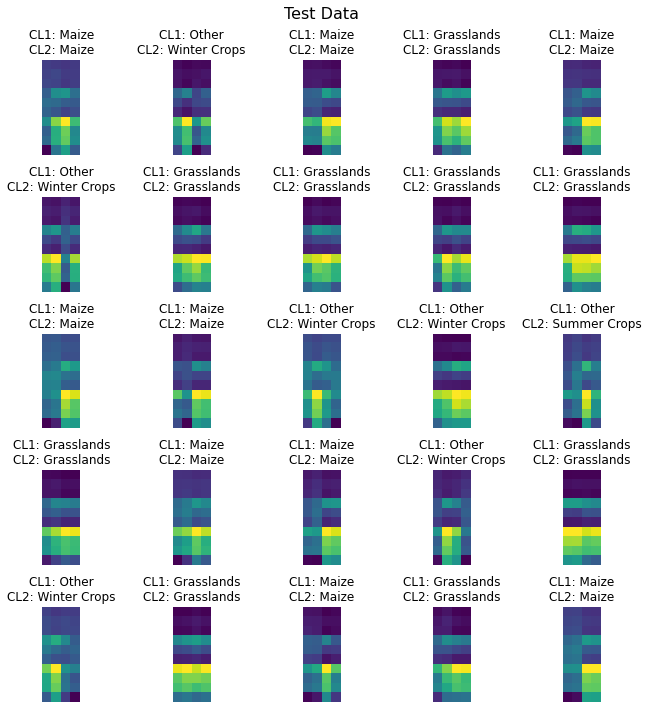

In [11]:
visualize_batch(s2_we_test_X_np, s2_we_test_Y_np_cl1, s2_we_test_Y_np_cl2, cl1_names, cl2_names, "Test Data")

### 3.2 DI and AOA

In [12]:
from sklearn.neighbors import BallTree
from scipy.spatial.distance import pdist, squareform
def aoa(new_data, 
        training_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       ):
    """
    Area of Applicability (AOA) measure for spatial prediction models from
    Meyer and Pebesma (2020). The AOA defines the area for which, on average, 
    the cross-validation error of the model applies, which is crucial for 
    cases where spatial predictions are used to inform decision-making.
    
    Parameters
    ----------
    new_data : GeoDataFrame
        A GeoDataFrame containing unseen data to measure AOA for.
    training_data : GeoDataFrame
        A GeoDataFrame containing the features used for model training.
    thres : default=0.95
        Threshold used to identify predictive area of applicability.
    fold_indices : iterable, default=None
        iterable consisting of training indices that identify instances in the
        folds.
    distance_metric : string, default='euclidean'
        Distance metric to calculate distances between new_data and training_data.
        Defaults to euclidean for projected CRS, otherwise haversine for unprojected.
    Returns
    -------
    DIs : array
        Array of disimimilarity scores between training_data for new_data points.
    masked_result : array
        Binary mask that occludes points outside predictive area of applicability.
    """
    
    
    if len(training_data) <= 1:
        raise Exception('At least two training instances need to be specified.')
                    
    # Scale data 
    training_data = (training_data - np.mean(training_data)) / np.std(training_data)
    new_data = (new_data - np.mean(new_data)) / np.std(new_data)

    # Calculate nearest training instance to test data, return Euclidean distances
    tree = BallTree(training_data, metric=distance_metric) 
    mindist, _ = tree.query(new_data, k=1, return_distance=True)

    # Build matrix of pairwise distances 
    paired_distances = pdist(training_data)
    train_dist = squareform(paired_distances)
    np.fill_diagonal(train_dist, np.nan)
    
    # Remove data points that are within the same fold
    if fold_indices:            
        # Get number of training instances in each fold
        instances_in_folds = [len(fold) for fold in fold_indices]
        instance_fold_id = np.repeat(np.arange(0, len(fold_indices)), instances_in_folds)

        # Create mapping between training instance and fold ID
        fold_indices = np.concatenate(fold_indices)
        folds = np.vstack((fold_indices, instance_fold_id)).T

        # Mask training points in same fold for DI measure calculation
        for i, row in enumerate(train_dist):
            mask = folds[:,0] == folds[:,0][i]
            train_dist[i, mask] = np.nan

    # Scale distance to nearest training point by average distance across training data
    train_dist_mean = np.nanmean(train_dist, axis=1)
    train_dist_avgmean = np.mean(train_dist_mean)
    mindist /= train_dist_avgmean    

    # Define threshold for AOA
    train_dist_min = np.nanmin(train_dist, axis=1)
    aoa_train_stats = np.quantile(train_dist_min / train_dist_avgmean, 
                                    q = np.array([0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))
    thres = np.quantile(train_dist_min / train_dist_avgmean, q = thres)
    
    # We choose the AOA as the area where the DI does not exceed the threshold
    DIs = mindist.reshape(-1)
    masked_result = np.repeat(1, len(mindist))
    masked_result[DIs > thres] = 0

    return DIs, masked_result, thres

In [13]:
org_train_data = pd.read_csv(r'./OriginalData_NH/L578_extract/s_nh_train_df.csv')
org_train_data = org_train_data.iloc[: , 1:]
# org_train_data

In [14]:
DI, Masked, thres = aoa(new_data=s2_we_test_X_df, 
        training_data=org_train_data, 
        model=None, 
        thres=0.95,
        fold_indices=None,
        distance_metric='euclidean'
       )

In [15]:
thres

0.2888197652967731

In [16]:
unique, counts = np.unique(Masked, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0  276634]
 [      1 1024842]]


## 4.0 Load Models

In [12]:
# CNN
deterministic_model_cl1 = load_model('./Out/CNN_Models/dcnn_model_cl1_trained.hdf5', compile=False)
deterministic_model_cl2 = load_model('./Out/CNN_Models/dcnn_model_cl2_trained.hdf5', compile=False)

# RF
rf_model_cl1 = joblib.load("./Out/RF_Models/rf_model_cl1_trained.joblib")
rf_model_cl2 = joblib.load("./Out/RF_Models/rf_model_cl2_trained.joblib")

2023-06-22 22:19:17.773586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:19:17.774014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:19:17.796593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:19:17.797026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 22:19:17.797447: I tensorflow/compiler/xla/stream_executo

## 5.0 Test Models

### 5.1 CNN model test

In [13]:
# Check traget system accuracy

cnn_model_s2_we_test_cl1_y_pred = deterministic_model_cl1.predict(s2_we_test_X_np)
cnn_model_s2_we_test_cl2_y_pred = deterministic_model_cl2.predict(s2_we_test_X_np)
# Convert predictions classes to one hot vectors
cnn_model_s2_we_test_cl1_y_pred_classes = np.argmax(cnn_model_s2_we_test_cl1_y_pred, axis = 1) 
cnn_model_s2_we_test_cl2_y_pred_classes = np.argmax(cnn_model_s2_we_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
cnn_model_s2_we_test_cl1_y_true = s2_we_test_Y_np_cl1
cnn_model_s2_we_test_cl2_y_true = s2_we_test_Y_np_cl2

# CM
cnn_model_s2_we_test_cl1_cm = confusion_matrix(cnn_model_s2_we_test_cl1_y_true, cnn_model_s2_we_test_cl1_y_pred_classes)
cnn_model_s2_we_test_cl2_cm = confusion_matrix(cnn_model_s2_we_test_cl2_y_true, cnn_model_s2_we_test_cl2_y_pred_classes)

# Accuracy
cnn_model_s2_we_test_cl1_acc = accuracy_score(y_true=cnn_model_s2_we_test_cl1_y_true, y_pred=cnn_model_s2_we_test_cl1_y_pred_classes, normalize=True)
cnn_model_s2_we_test_cl2_acc = accuracy_score(y_true=cnn_model_s2_we_test_cl2_y_true, y_pred=cnn_model_s2_we_test_cl2_y_pred_classes, normalize=True)

# Macro F1
cnn_model_s2_we_test_cl1_macroF1 = f1_score(y_true=cnn_model_s2_we_test_cl1_y_true, y_pred=cnn_model_s2_we_test_cl1_y_pred_classes, average='macro')
cnn_model_s2_we_test_cl2_macroF1 = f1_score(y_true=cnn_model_s2_we_test_cl2_y_true, y_pred=cnn_model_s2_we_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S2 CNN NH Model CL1 Test')
print(cnn_model_s2_we_test_cl1_cm)
print("Test accuracy for S2 CNN NH model for CL1: " + str(round(cnn_model_s2_we_test_cl1_acc, 3)))
print("Test MacroF1 for S2 CNN NH model for CL1: " + str(round(cnn_model_s2_we_test_cl1_macroF1, 3)))
print("=================================\n")
print('S2 CNN NH Model CL2 Test')
print(cnn_model_s2_we_test_cl2_cm)
print("Test accuracy for S2 CNN NH model for CL2: " + str(round(cnn_model_s2_we_test_cl2_acc, 3)))
print("Test MacroF1 for S2 CNN NH model for CL2: " + str(round(cnn_model_s2_we_test_cl2_macroF1, 3)))

2023-06-22 22:19:31.982925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


48273/48273 [==============================] - 60s 1ms/step

S2 CNN NH Model CL1 Test
[[299411  15400  84366]
 [ 41789 363836  35951]
 [ 11994   1934 690048]]
Test accuracy for S2 CNN NH model for CL1: 0.876
Test MacroF1 for S2 CNN NH model for CL1: 0.864

S2 CNN NH Model CL2 Test
[[  4283   2547  11490   1254    416]
 [ 13379 382456  37295   8057    389]
 [  8663   2677 691235    817    584]
 [ 12121  19610  33297  35113   2305]
 [ 27708   4086  66318  13140 165489]]
Test accuracy for S2 CNN NH model for CL2: 0.828
Test MacroF1 for S2 CNN NH model for CL2: 0.614


In [14]:
cnn_model_s2_we_test_cl1_clsF1 = f1_score(y_true=cnn_model_s2_we_test_cl1_y_true, y_pred=cnn_model_s2_we_test_cl1_y_pred_classes, average=None)

cnn_s2_cl1_f1 = [list(cl1_names.values()), cnn_model_s2_we_test_cl1_clsF1.tolist()]
cnn_s2_cl1_f1_df = pd.DataFrame(cnn_s2_cl1_f1)
cnn_s2_cl1_f1_df = cnn_s2_cl1_f1_df.transpose()
 
# specifying column names
cnn_s2_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 CNN NH Model CL1 Test')
cnn_s2_cl1_f1_df



S2 CNN NH Model CL1 Test


,Class,F1
0,Other,0.795913
1,Maize,0.884443
2,Grasslands,0.911351


In [15]:
cnn_model_s2_we_test_cl2_clsF1 = f1_score(y_true=cnn_model_s2_we_test_cl2_y_true, y_pred=cnn_model_s2_we_test_cl2_y_pred_classes, average=None)

cnn_s2_cl2_f1 = [list(cl2_names.values()), cnn_model_s2_we_test_cl2_clsF1.tolist()]
cnn_s2_cl2_f1_df = pd.DataFrame(cnn_s2_cl2_f1)
cnn_s2_cl2_f1_df = cnn_s2_cl2_f1_df.transpose()
 
# specifying column names
cnn_s2_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 CNN NH Model CL2 Test')
cnn_s2_cl2_f1_df



S2 CNN NH Model CL2 Test


,Class,F1
0,Other,0.099438
1,Maize,0.896782
2,Grasslands,0.895608
3,Summer Crops,0.436656
4,Winter Crops,0.74223


### 5.2 RF Model Test

In [16]:
# Check target system accuracy

rf_model_s2_we_test_cl1_y_pred = rf_model_cl1.predict(s2_we_test_X_df)
rf_model_s2_we_test_cl2_y_pred = rf_model_cl2.predict(s2_we_test_X_df)

# Convert predictions classes to one hot vectors 9
rf_model_s2_we_test_cl1_y_pred_classes = rf_model_s2_we_test_cl1_y_pred # np.argmax(rf_model_s2_we_test_cl1_y_pred, axis = 1) 
rf_model_s2_we_test_cl2_y_pred_classes = rf_model_s2_we_test_cl2_y_pred # np.argmax(rf_model_s2_we_test_cl2_y_pred, axis = 1)
# Convert test data to one hot vectors
rf_model_s2_we_test_cl1_y_true = s2_we_test_Y_np_cl1
rf_model_s2_we_test_cl2_y_true = s2_we_test_Y_np_cl2

# CM
rf_model_s2_we_test_cl1_cm = confusion_matrix(rf_model_s2_we_test_cl1_y_true, rf_model_s2_we_test_cl1_y_pred_classes)
rf_model_s2_we_test_cl2_cm = confusion_matrix(rf_model_s2_we_test_cl2_y_true, rf_model_s2_we_test_cl2_y_pred_classes)

# Accuracy
rf_model_s2_we_test_cl1_acc = accuracy_score(y_true=rf_model_s2_we_test_cl1_y_true, y_pred=rf_model_s2_we_test_cl1_y_pred_classes, normalize=True)
rf_model_s2_we_test_cl2_acc = accuracy_score(y_true=rf_model_s2_we_test_cl2_y_true, y_pred=rf_model_s2_we_test_cl2_y_pred_classes, normalize=True)

# Macro F1
rf_model_s2_we_test_cl1_macroF1 = f1_score(y_true=rf_model_s2_we_test_cl1_y_true, y_pred=rf_model_s2_we_test_cl1_y_pred_classes, average='macro')
rf_model_s2_we_test_cl2_macroF1 = f1_score(y_true=rf_model_s2_we_test_cl2_y_true, y_pred=rf_model_s2_we_test_cl2_y_pred_classes, average='macro')

print("=================================\n")
print('S2 RF NH Model CL1 Test')
print(rf_model_s2_we_test_cl1_cm)
print("Test accuracy for S2 RF NH model for CL1: " + str(round(rf_model_s2_we_test_cl1_acc, 3)))
print("Test MacroF1 for S2 RF NH model for CL1: " + str(round(rf_model_s2_we_test_cl1_macroF1, 3)))
print("=================================\n")
print('S2 RF NH Model CL2 Test')
print(rf_model_s2_we_test_cl2_cm)
print("Test accuracy for S2 RF NH model for CL2: " + str(round(rf_model_s2_we_test_cl2_acc, 3)))
print("Test MacroF1 for S2 RF NH model for CL2: " + str(round(rf_model_s2_we_test_cl2_macroF1, 3)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   14.7s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:   20.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    7.4s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   17.5s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:   24.5s finished



S2 RF NH Model CL1 Test
[[321721  24211  53245]
 [ 41621 376857  23098]
 [ 17643   3066 683267]]
Test accuracy for S2 RF NH model for CL1: 0.895
Test MacroF1 for S2 RF NH model for CL1: 0.883

S2 RF NH Model CL2 Test
[[  4767   2884   9803   2123    413]
 [ 15035 387570  27323  11194    454]
 [  9883   3625 687749   1976    743]
 [ 13135  23487  19840  43032   2952]
 [ 18820   3064  48596  16765 189496]]
Test accuracy for S2 RF NH model for CL2: 0.85
Test MacroF1 for S2 RF NH model for CL2: 0.645


In [17]:
rf_model_s2_we_test_cl1_clsF1 = f1_score(y_true=rf_model_s2_we_test_cl1_y_true, y_pred=rf_model_s2_we_test_cl1_y_pred_classes, average=None)

rf_s2_cl1_f1 = [list(cl1_names.values()), rf_model_s2_we_test_cl1_clsF1.tolist()]
rf_s2_cl1_f1_df = pd.DataFrame(rf_s2_cl1_f1)
rf_s2_cl1_f1_df = rf_s2_cl1_f1_df.transpose()
 
# specifying column names
rf_s2_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 RF NH Model CL1 Test')
rf_s2_cl1_f1_df



S2 RF NH Model CL1 Test


,Class,F1
0,Other,0.824754
1,Maize,0.89122
2,Grasslands,0.933689


In [18]:
rf_model_s2_we_test_cl2_clsF1 = f1_score(y_true=rf_model_s2_we_test_cl2_y_true, y_pred=rf_model_s2_we_test_cl2_y_pred_classes, average=None)

rf_s2_cl2_f1 = [list(cl2_names.values()), rf_model_s2_we_test_cl2_clsF1.tolist()]
rf_s2_cl2_f1_df = pd.DataFrame(rf_s2_cl2_f1)
rf_s2_cl2_f1_df = rf_s2_cl2_f1_df.transpose()
 
# specifying column names
rf_s2_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('S2 RF NH Model CL2 Test')
rf_s2_cl2_f1_df



S2 RF NH Model CL2 Test


,Class,F1
0,Other,0.116795
1,Maize,0.899019
2,Grasslands,0.91866
3,Summer Crops,0.484769
4,Winter Crops,0.804997


## 6.0 Get model outputs

In [19]:
s2_base = s2_we_test_df.iloc[:, [0, 1, 2]]

### 6.1 CNN

In [20]:
s2_cnn_out_df = s2_base.copy()

s2_cnn_out_df['cl1_true'] = (np.array(cnn_model_s2_we_test_cl1_y_true, int)).tolist()

s2_cnn_out_df['cl1_pred'] = cnn_model_s2_we_test_cl1_y_pred_classes.tolist()

s2_cnn_out_df['cl2_true'] = (np.array(cnn_model_s2_we_test_cl2_y_true, int)).tolist()

s2_cnn_out_df['cl2_pred'] = cnn_model_s2_we_test_cl2_y_pred_classes.tolist()

# s2_cnn_out_df['DI'] = DI.tolist()

# s2_cnn_out_df['AOA'] = Masked.tolist()

s2_cnn_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred
599440,2013_000001,2013,MZ,1,0,1,1
599441,2013_000002,2013,PG,2,2,2,2
599442,2013_000003,2013,WC,0,0,4,0
599443,2013_000004,2013,MZ,1,1,1,1
599444,2013_000005,2013,MZ,1,1,1,1
...,...,...,...,...,...,...,...
2145046,2018_266054,2018,PG,2,2,2,2
2145047,2018_266055,2018,MZ,1,0,1,1
2145048,2018_266056,2018,MZ,1,0,1,1
2145049,2018_266057,2018,PG,2,2,2,2


In [21]:
s2_cnn_out_df.to_csv('./Out/CNN_Models/s2_cnn_out.csv')

### 6.2 RF

In [22]:
s2_rf_out_df = s2_base.copy()

s2_rf_out_df['cl1_true'] = (np.array(rf_model_s2_we_test_cl1_y_true, int)).tolist()

s2_rf_out_df['cl1_pred'] = rf_model_s2_we_test_cl1_y_pred_classes.tolist()

s2_rf_out_df['cl2_true'] = (np.array(rf_model_s2_we_test_cl2_y_true, int)).tolist()

s2_rf_out_df['cl2_pred'] = rf_model_s2_we_test_cl2_y_pred_classes.tolist()

# s2_rf_out_df['DI'] = DI.tolist()

# s2_rf_out_df['AOA'] = Masked.tolist()

s2_rf_out_df

,p_id,year,CAT,cl1_true,cl1_pred,cl2_true,cl2_pred
599440,2013_000001,2013,MZ,1,1.0,1,1.0
599441,2013_000002,2013,PG,2,2.0,2,2.0
599442,2013_000003,2013,WC,0,2.0,4,2.0
599443,2013_000004,2013,MZ,1,1.0,1,1.0
599444,2013_000005,2013,MZ,1,1.0,1,1.0
...,...,...,...,...,...,...,...
2145046,2018_266054,2018,PG,2,2.0,2,2.0
2145047,2018_266055,2018,MZ,1,1.0,1,1.0
2145048,2018_266056,2018,MZ,1,1.0,1,1.0
2145049,2018_266057,2018,PG,2,2.0,2,2.0


In [23]:
s2_rf_out_df.to_csv('./Out/RF_Models/s2_rf_out.csv')